In [2]:
import pandas as pd
import numpy as np

# Carregando datasets

In [3]:
dataretrieve = pd.read_csv("..//datasets/dataretrieve.csv", na_values='?')
desharnais = pd.read_csv("..//datasets/desharnais.csv", na_values='?')
dataretrieve = dataretrieve.fillna(0)
desharnais = desharnais.fillna(0)

# PCA

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
def myPCA(dataset, components):
    #A última coluna é a classe
    dataX = dataset.loc[:,dataset.columns[:-1]].values
    dataY = dataset.loc[:,[dataset.columns[-1]]].values
    
    dataXstd = StandardScaler().fit_transform(dataX)
    
    covMat = np.cov(dataXstd.T)
    
    eigVals, eigVecs = np.linalg.eig(covMat)
    
    eigPairs = [(np.abs(eigVals[i]), eigVecs[:,i]) for i in range(len(eigVals))]
    eigPairs = sorted(eigPairs, key=lambda k: k[0], reverse=True)
    
    totalInfo = sum(eigVals)
    infoCovered = [(i / totalInfo) for i in sorted(eigVals, reverse=True)]
    cumInfoCovered = np.cumsum(infoCovered)
    
    pos = 0
    if(components == 0):
        for i in range(len(cumInfoCovered)):
            if(i==len(cumInfoCovered)-1):
                pos = i-1
                break
            if (cumInfoCovered[i] > 0.9):
                pos = i
                break
    else:
        pos = components - 1
    
    matrixW = np.hstack((eigPairs[0][1].reshape(len(eigVals),1)))
    
    for j in range(1, pos+1):
        matrixW = np.c_[matrixW, eigPairs[j][1].reshape(len(eigVals),1)]
        
    transformedData = dataXstd.dot(matrixW)
    
    return transformedData, matrixW

# Knn x Nº de Componentes

In [6]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [7]:
def calcScores(dataset):
    knn = KNeighborsClassifier(n_neighbors=3)
    dataY = dataset.loc[:,[dataset.columns[-1]]].values.ravel()
    #c, r = dataY.shape
    #dataY = dataY.reshape(c,)
    scores = []
    pcs = []
    for i in range(1,len(dataset.columns)):
        transformedData, matrixW = myPCA(dataset, i)
        if(i==1):
            transformedData = transformedData.reshape((transformedData.shape[0],1))
        compScores = cross_val_score(knn, transformedData, dataY, cv=5, scoring='accuracy')
        scores.append(np.mean(compScores))
        pcs.append(i)
    return scores, pcs

# Resultados PCA

In [8]:
#Warning por conta da conversão dos valores do dataset para dados normalizados
dataretrieveScores, dataretrievePcs = calcScores(dataretrieve)
desharnaisScores, desharnaisPcs = calcScores(desharnais)

/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Da

In [9]:
dataretrieveScores

[0.90793162393162397,
 0.90793162393162397,
 0.88393162393162394,
 0.88393162393162394,
 0.88393162393162394,
 0.89962393162393162,
 0.89962393162393162,
 0.89962393162393162]

In [10]:
desharnaisScores

[0.43382352941176466,
 0.51764705882352946,
 0.53014705882352942,
 0.60514705882352948,
 0.59264705882352942,
 0.58014705882352946,
 0.58014705882352946,
 0.55514705882352944,
 0.55514705882352944,
 0.55514705882352944,
 0.55514705882352944]

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

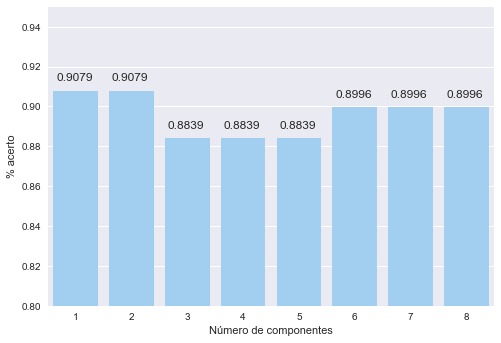

In [12]:
plt.ylim((0.80,0.95))
ax = sns.barplot(x=dataretrievePcs, y=dataretrieveScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de componentes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=4), (p.get_x()+0.05, p.get_height()+0.005))
plt.savefig("..//results/dataretrievePCA.jpg")
plt.show()

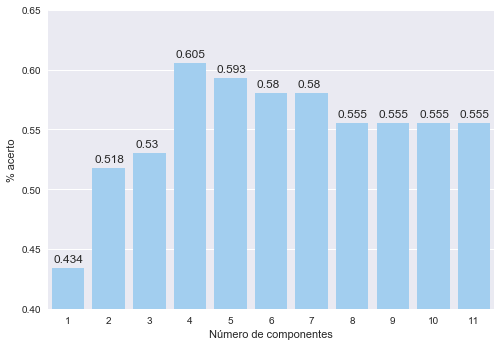

In [13]:
plt.ylim((0.40,0.65))
ax = sns.barplot(x=desharnaisPcs, y=desharnaisScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de componentes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=3), (p.get_x()+0.05, p.get_height()+0.005))
plt.savefig("..//results/desharnaisPCA.jpg")
plt.show()

# LDA

In [14]:
def myLDA(dataset, components):
    
    dim = len(dataset.columns)-1
    classList = dataset[dataset.columns[-1]].unique()
    classCount = len(classList)
    
    dataX = dataset.loc[:,dataset.columns[:-1]].values
    dataY = dataset.loc[:,[dataset.columns[-1]]].values
    
    dataXstd = StandardScaler().fit_transform(dataX)
    
    classInstances = []
    for i in range(classCount):
        myList = []
        for j in range(len(dataY)):
                if ((dataY==classList[i])[j] == True):
                    myList.append(j)
        classInstances.append(myList)
        
    meanVectors = []
    
    for i in range(classCount):
        meanVectors.append(np.mean(dataXstd[classInstances[i]], axis=0))
    
    Sw = np.zeros((dim,dim))
    
    for i in range(classCount):
        Si = np.zeros((dim,dim))
        for j in range(len(classInstances[i])):
            row = dataXstd[classInstances[i]][j].reshape(dim,1)
            vec = meanVectors[i].reshape(dim,1)
            Si = Si + ((row - vec).dot((row - vec).T))
        Sw = Sw + Si
    
    meanVec = np.mean(dataXstd, axis=0)
    Sb = np.zeros((dim,dim))
    
    for i in range(classCount):
        ni = len(classInstances[i])
        vec = meanVectors[i].reshape(dim,1)
        mvec = meanVec.reshape(dim,1)
        
        Sb = Sb + (ni * ((vec - mvec).dot((vec - mvec).T)))
    
    eigVals, eigVecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    
    eigPairs = [(np.abs(eigVals[i]), eigVecs[:,i]) for i in range(len(eigVals))]
    eigPairs = sorted(eigPairs, key=lambda k: k[0], reverse=True)
    
    matrixW = np.hstack((eigPairs[0][1].reshape(len(eigVals),1)))
    
    pos = components - 1
    
    for j in range(1, pos+1):
        matrixW = np.c_[matrixW, eigPairs[j][1].reshape(len(eigVals),1)]
        
    transformedData = dataXstd.dot(matrixW)
    
    return transformedData, matrixW

# Knn x Nº de Discriminantes

In [15]:
def calcScoresLDA(dataset):
    knn = KNeighborsClassifier(n_neighbors=3)
    dataY = dataset.loc[:,[dataset.columns[-1]]].values.ravel()
    scores = []
    discs = []
    
    dim = len(dataset.columns)-1
    classList = dataset[dataset.columns[-1]].unique()
    classCount = len(classList)
    discsNumbers = classCount
    if(dim<classCount):
        discsNumbers = dim
    
    for i in range(1,discsNumbers):
        transformedData, matrixW = myLDA(dataset, i)
        if(i==1):
            transformedData = transformedData.reshape((transformedData.shape[0],1))
        compScores = cross_val_score(knn, transformedData, dataY, cv=5, scoring='accuracy')
        scores.append(np.mean(compScores))
        discs.append(i)
    return scores, discs

# Resultados LDA

In [16]:
dataretrieveLDAScores, dataretrieveDiscs = calcScoresLDA(dataretrieve)
desharnaisLDAScores, desharnaisDiscs = calcScoresLDA(desharnais)

/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/Users/ajgan/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary

In [17]:
dataretrieveLDAScores

[0.91562393162393163]

In [18]:
desharnaisLDAScores

[0.62941176470588234, 0.70514705882352946]

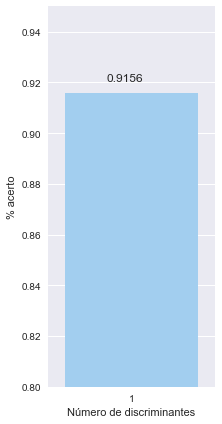

In [32]:
plt.figure(figsize=(3,7))
plt.ylim((0.8,0.95))
ax = sns.barplot(x=dataretrieveDiscs, y=dataretrieveLDAScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de discriminantes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=4), (p.get_x()+0.25, p.get_height()+0.005))
plt.savefig("..//results/dataretrieveLDA.jpg")
plt.show()

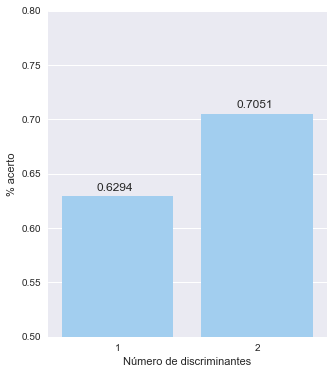

In [21]:
plt.figure(figsize=(5,6))
plt.ylim((0.5,0.8))
ax = sns.barplot(x=desharnaisDiscs, y=desharnaisLDAScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de discriminantes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=4), (p.get_x()+0.25, p.get_height()+0.005))
plt.savefig("..//results/desharnaisLDA.jpg")
plt.show()

# PCA x LDA

In [69]:
d = dict(PCA = dataretrieveScores, LDA = dataretrieveLDAScores, Dimensions = dataretrievePcs)
dataretrievePcaLda = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

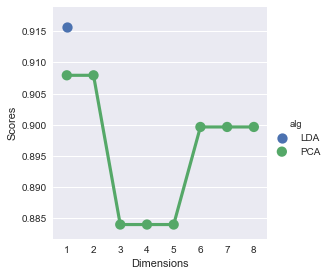

In [84]:
dataretrievePcaLda2 = dataretrievePcaLda.melt('Dimensions', var_name='alg',  value_name='Scores')
g = sns.factorplot(x="Dimensions", y="Scores", hue='alg', data=dataretrievePcaLda2)
plt.savefig("..//results/dataretrievePCAxLDA.jpg")
plt.show()

In [80]:
d2 = dict(PCA = desharnaisScores, LDA = desharnaisLDAScores, Dimensions = desharnaisPcs)
desharnaisPcaLda = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d2.items() ]))

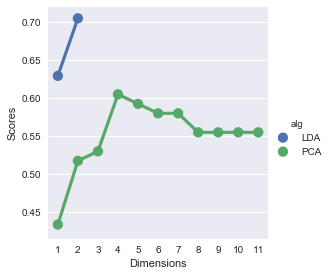

In [83]:
desharnaisPcaLda2 = desharnaisPcaLda.melt('Dimensions', var_name='alg',  value_name='Scores')
g = sns.factorplot(x="Dimensions", y="Scores", hue='alg', data=desharnaisPcaLda2)
plt.savefig("..//results/desharnaisPCAxLDA.jpg")
plt.show()